In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
churn_raw = pd.read_csv(Path("Churn_Modelling.csv"))
churn = churn_raw.copy()
print(churn.info())
churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**My initial breakdown of the data:**
* there are no missing values
* Dtype of most of the features are in ints and floats
* gender and geography has to be labeled
* drop potenitally useless features (RowNum, surname)
* Have to find the relationship between each of the category with Exited
* we have to predict the probability of Exited aka 'churned'

In [4]:
churn["is_female"] = churn['Gender'].map({'Male': 0, 'Female': 1})

cat_encoder = LabelEncoder()
churn["Geo"] = cat_encoder.fit_transform(churn[['Geography']])

In [5]:
churn.drop(['CustomerId', 'RowNumber', 'Surname', 'Gender', 'Geography'], axis = 1, inplace= True, errors='ignore')
churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,is_female,Geo
0,619,42,2,0.00,1,1,1,101348.88,1,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,2
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,2


In [14]:
churn["CreditScore_log"] = np.log(churn["CreditScore"] + 1)

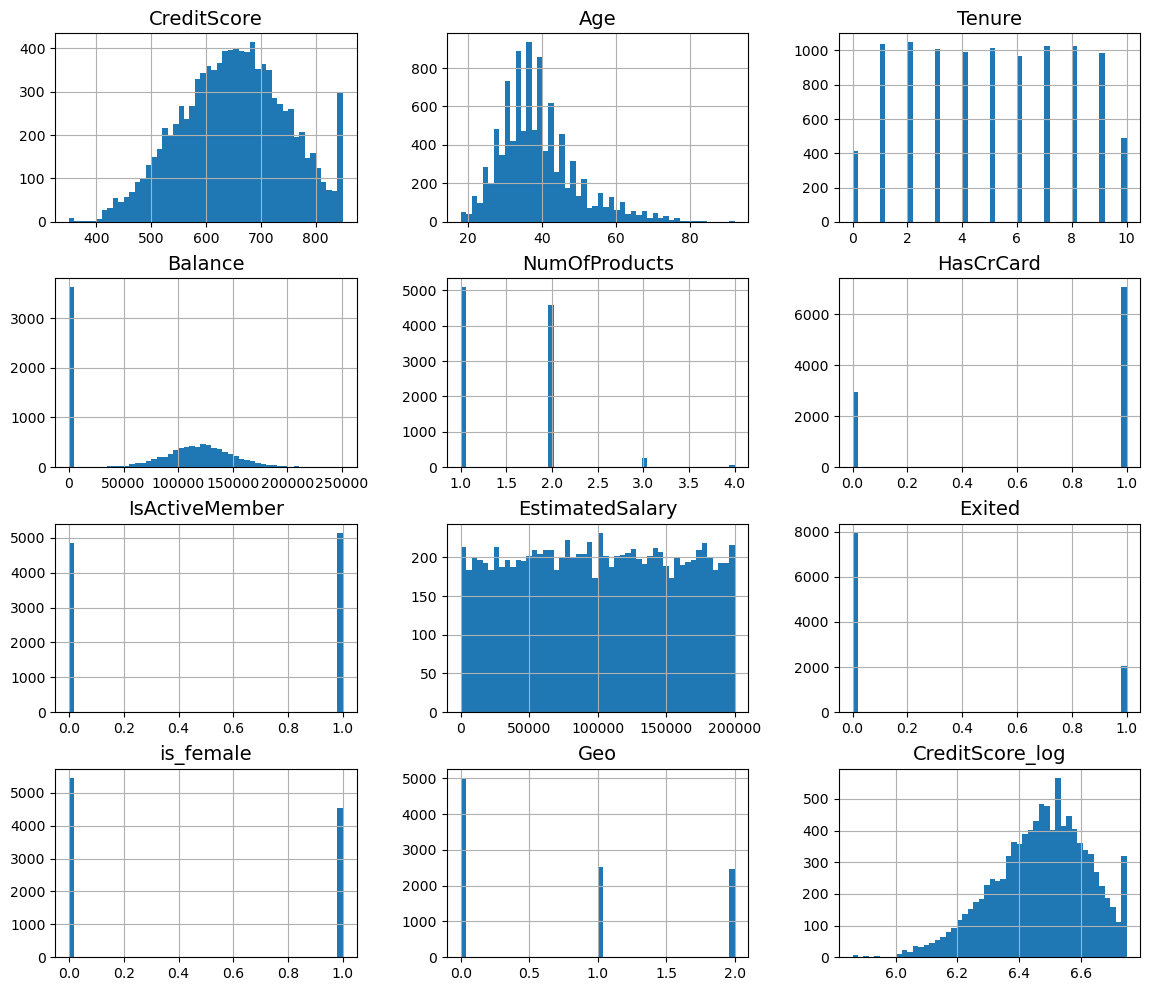

In [15]:
mp.rc('font', size=12)
mp.rc('axes', labelsize=14, titlesize=14)
mp.rc('legend', fontsize=12)
mp.rc('xtick', labelsize=10)
mp.rc('ytick', labelsize=10)

churn.hist(bins=50, figsize=(14,12))
mp.show()

The log isn't helping at all here

In [16]:
max_age = churn["Age"].max() + 1
binns = [0, 20, 40, 60, 80, 100, max_age] if max_age > 100 else [0, 20, 40, 60, 80, 100]
churn["Age_Cat"] = pd.cut(churn["Age"], bins=binns, labels=["Teen", "Young_Adult", "Adult", "Senior", "Super-Senior"], right=False)
print(churn["Age_Cat"].isnull().sum())

0


In [17]:
x=churn.drop(columns='Exited')
y=churn['Exited']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=42,
                                               stratify=churn["Age_Cat"])

for set_ in (x_train,x_test):
  set_.drop("Age_Cat", inplace=True, axis=1)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [18]:
model1 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)

r1 = classification_report(y_test, y_pred1)
print(r1)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2382
           1       0.87      0.34      0.49       618

    accuracy                           0.85      3000
   macro avg       0.86      0.66      0.70      3000
weighted avg       0.86      0.85      0.83      3000



In [19]:
model2 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_features=6)
model2.fit(x_train,y_train)
y_pred2 = model2.predict(x_test)

r2 = classification_report(y_test, y_pred2)
print(r2)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2382
           1       0.81      0.48      0.60       618

    accuracy                           0.87      3000
   macro avg       0.84      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



In [20]:
model3 = LogisticRegression(random_state=42)
model3.fit(x_train,y_train)
y_pred3 = model3.predict(x_test)

r3 = classification_report(y_test, y_pred3)
print(r3)

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2382
           1       0.68      0.16      0.26       618

    accuracy                           0.81      3000
   macro avg       0.75      0.57      0.58      3000
weighted avg       0.79      0.81      0.76      3000



In [21]:
model4 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=30,
                            learning_rate=0.5, random_state=42)
model4.fit(x_train,y_train)
y_pred4 = model4.predict(x_test)

r4 = classification_report(y_test, y_pred4)
print(r4)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2382
           1       0.79      0.48      0.60       618

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.85      3000



* Model 1 (Random Forest) has a good accuracy but struggles significantly with class 1, making it less reliable for balanced detection of both classes.

* Models 2 and 4 (Gradient Boosting and AdaBoost) have the best overall performance, especially considering class 1's metrics.

* Model 3 (Logistic Regression) performs poorly on class 1 and should not be preferred if detecting class 1 accurately is important.